# Load Library

In [242]:
# load the library for path
from pathlib import Path
import openpyxl as xl
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import *
from datetime import datetime
from statsmodels import *
import ipywidgets as widgets
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import seaborn as sns
from math import sqrt
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from pmdarima.utils import diff_inv



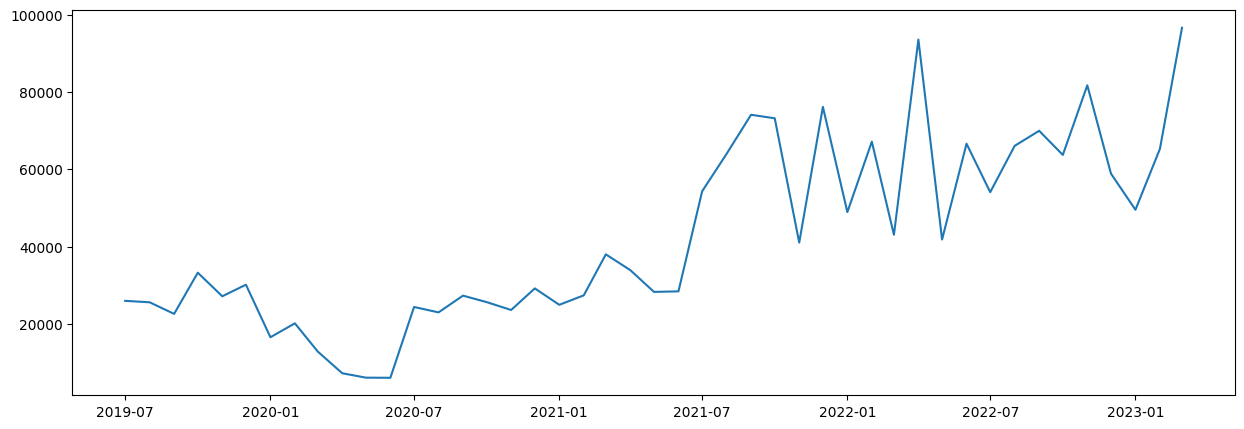

In [239]:
# import data set
data_dir = Path('../datathon')

# read xlsx data set
df = pd.read_csv(data_dir/'Total Online Job Vacancy.csv', index_col = [0], parse_dates=[0])

# remove all the empty column
df = df.dropna(axis=1, how='all')

# change dtypes to time series
df.index = pd.to_datetime(df.index)

plt.figure(figsize=(15, 5))
plt.plot(df)

# 3. Test for Data Set
## 3.1 Stationary Test

In [ ]:
# perform the stationarity test
Total_mean = df['Total'].rolling(3).mean()
Total_std = df['Total'].rolling(3).std()

plt.plot(df, color = "black", label='Job Vacancy')
plt.plot(Total_mean, color = "red", label='Job Vacancy')
plt.plot(Total_std, color = "green", label='Job Vacancy')
plt.title('Total Rate from 2010 to 2023 in Malaysia')
plt.legend(loc = "best")


In [ ]:

# perform the stationarity test
adft = adfuller(df.Total, autolag='AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)


## 3.2 Autocorrelation

In [ ]:
autocorrelation_lag1 = df.Total.autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df.Total.autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df.Total.autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df.Total.autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.dropna(), ax=ax[1], lags=20)

In [ ]:
## 3.3 Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Total'], model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid


In [ ]:

plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(411)
plt.plot(df.Total)
plt.title('Original Time Series')

# Trend component
plt.subplot(412)
plt.plot(trend)
plt.title('Trend Component')

# Seasonal component
plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal Component')

# Residual component
plt.subplot(414)
plt.plot(residual)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


# 4. Data Transformation


In [ ]:
df_diff = df.diff().dropna()

# perform the stationarity test
adft = adfuller(df_diff.Total, autolag='AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_diff.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df_diff.dropna(), ax=ax[1], lags=20)

# 5. Split the Data set into train and test set

In [ ]:
import matplotlib.pyplot as plt
# split the data set into train and test with 80% and 20% respectively
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]
train.shape, test.shape

# 6. Fitting the Model

## ETS

In [ ]:
# split the data set into train and test
train_diff = df[:len(df)-12]
test_diff = df[len(df)-12:]
train_diff.shape, test_diff.shape

### ETS Accuracy Testing

In [214]:
diff = len(train_diff)- len(test_diff)
model = ExponentialSmoothing(train_diff, trend='add', seasonal='add', seasonal_periods=12)  
model_fit = model.fit()
forecast = model_fit.forecast(steps= 12)

mae = mean_absolute_error(test_diff, forecast)
mse = mean_squared_error(test_diff, forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape(test_diff, forecast)
print(f"Mean Absolute Percentage Error (MAPE): {mape(test_diff, forecast):.2f}%")
print('\n')


Mean Absolute Error (MAE): 13849.78
Mean Squared Error (MSE): 395751044.49
Root Mean Squared Error (RMSE): 19893.49
Mean Absolute Percentage Error (MAPE): nan%




c:\Users\TAN YU JING\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\TAN YU JING\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_diff, label='Actual', linestyle='-', marker='o')
plt.plot(forecast, label='Forecast', linestyle='--', marker='o')
plt.plot(test_diff, label='Actual', linestyle='-', marker='o') 
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

## ARIMA test

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=698.728, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=703.470, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=695.841, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=698.910, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=701.535, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=697.306, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=697.350, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=699.235, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=694.415, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=695.722, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=695.737, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=697.537, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=697.669, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.687 seconds


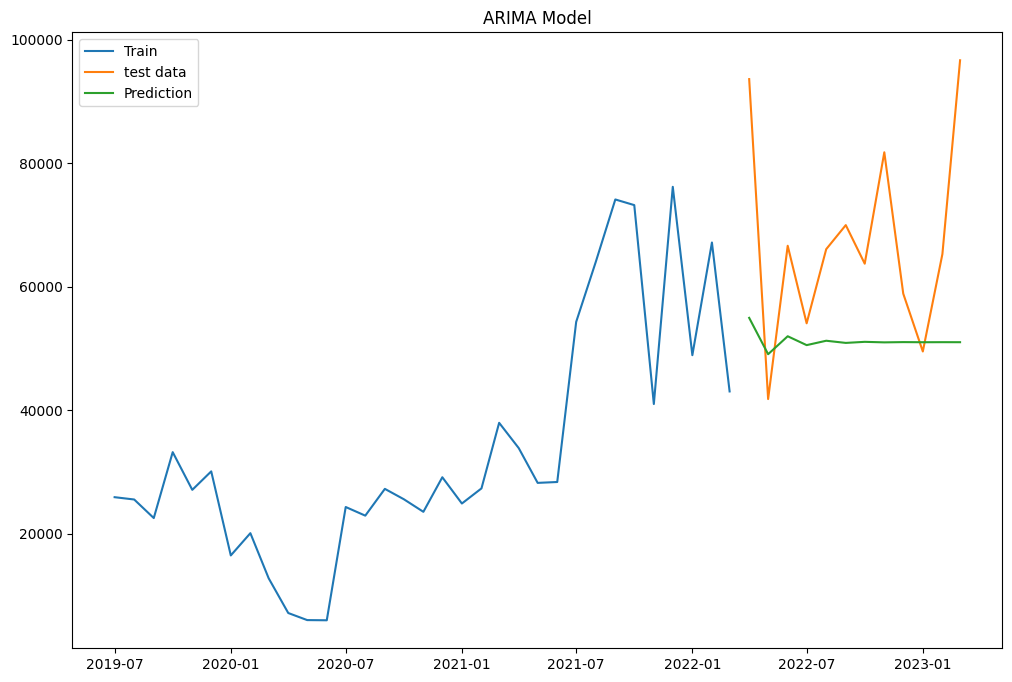

In [215]:
model = auto_arima(train_diff, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_diff)
forecast = model.predict(n_periods=len(test_diff))
forecast = pd.DataFrame(forecast,index = test_diff.index,columns=['Prediction'])

# plot the predictions for validation set
plt.figure(figsize=(12,8))
plt.plot(train_diff, label='Train')
plt.plot(test_diff, label='test data')
plt.plot(forecast, label='Prediction')
plt.title('ARIMA Model')
plt.legend(loc='best')

### ARIMA Accuracy Testing

In [216]:
mae = mean_absolute_error(test_diff, forecast)
mse = mean_squared_error(test_diff, forecast)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 17562.52
Mean Squared Error (MSE): 484963161.30
Root Mean Squared Error (RMSE): 22021.88


# 5. Linear Regression with Time Series

## 5.1 Fit the feature

### 5.1.1 Create Trend Feature

<Axes: title={'center': 'Job Vacancy'}, xlabel='Advertised Date'>

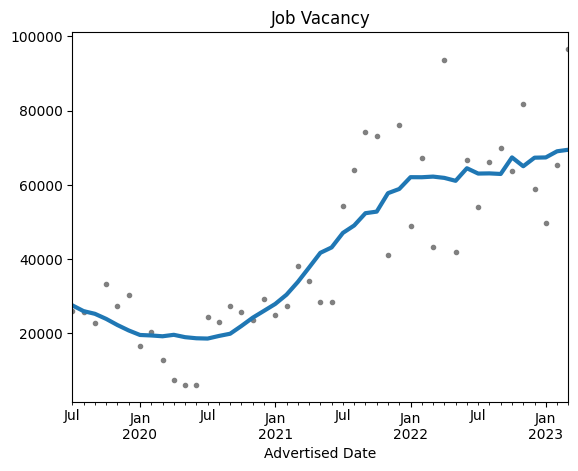

In [217]:
moving_average = df.Total.rolling(
    window=12,       # 12-months window
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df.Total.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Job Vacancy", legend=False,
)

In [218]:
train['count'] = range(1, len(train) + 1)

X = train[['count']]  # features
y = train['Total']  # target

# create the trend feature
dp = DeterministicProcess(
    index=train.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()
X

,const,trend,trend_squared
Advertised Date,,,
2019-07-01,1.0,1.0,1.0
2019-08-01,1.0,2.0,4.0
2019-09-01,1.0,3.0,9.0
2019-10-01,1.0,4.0,16.0
2019-11-01,1.0,5.0,25.0
2019-12-01,1.0,6.0,36.0
2020-01-01,1.0,7.0,49.0
2020-02-01,1.0,8.0,64.0
2020-03-01,1.0,9.0,81.0


### 5.1.2 Create Seasonality

In [220]:
# Assuming you have the 'train' DataFrame with a date column
# Convert the date column to a DateTimeIndex
#train['date'] = pd.to_datetime(train['date'])
#train.index = train['date']

# Calculate the quarter for each timestamp
train['quarter'] = (train.index.month - 1) // 3 + 1

# Create quarterly seasonality indicator variables
train['quarter_Q1'] = (train['quarter'] == 1).astype(int)
train['quarter_Q2'] = (train['quarter'] == 2).astype(int)
train['quarter_Q3'] = (train['quarter'] == 3).astype(int)
train['quarter_Q4'] = (train['quarter'] == 4).astype(int)

# Create the feature matrix (X) including quarterly seasonality indicators
X1 = train[['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4']]
X1

# remove the quarter column in train
train = train.drop(['quarter_Q1'], axis=1)
train = train.drop(['quarter_Q2'], axis=1)
train = train.drop(['quarter_Q3'], axis=1)
train = train.drop(['quarter_Q4'], axis=1)

In [221]:
#train['date'] = train.index
X['date'] = train.index
#X['date']  = X.index
X.index = pd.to_datetime(X.index)

# Create Seosonal Feature
fourier = CalendarFourier(freq="M", order=12)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index= train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                  # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index


c:\Users\TAN YU JING\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:1246: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  is_constant[const_locs[:1]] = False


In [222]:
train.index = pd.to_datetime(train.index, unit='s')
train.index

DatetimeIndex(['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
              dtype='datetime64[ns]', name='Advertised Date', freq=None)

## 5.2 Fit the Model

In [223]:
X.head()
test.index

DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01'],
              dtype='datetime64[ns]', name='Advertised Date', freq=None)

<Axes: title={'center': 'Unemployment Rate'}, xlabel='Advertised Date'>

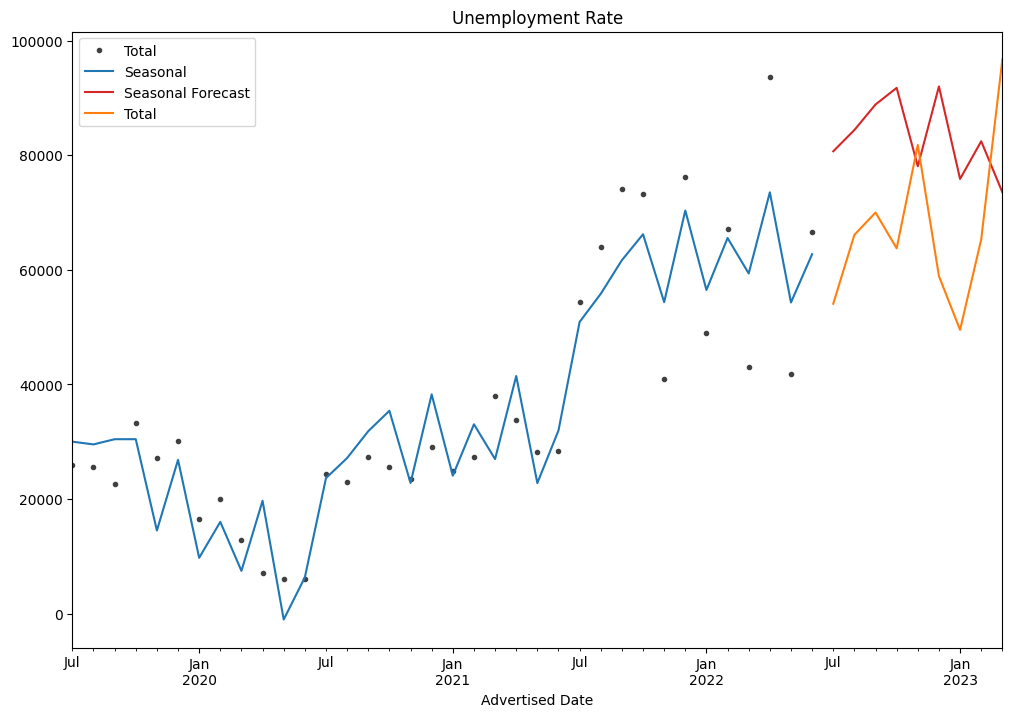

In [224]:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index= y.index)
X_fore = dp.out_of_sample(steps=9, forecast_index=test.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Unemployment Rate")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()
test['Total'].plot(legend=True, figsize=(12,8))

Text(0.5, 1.0, 'Time Plot of Jjob Vacancy from 2010 to 2023 in Malaysia')

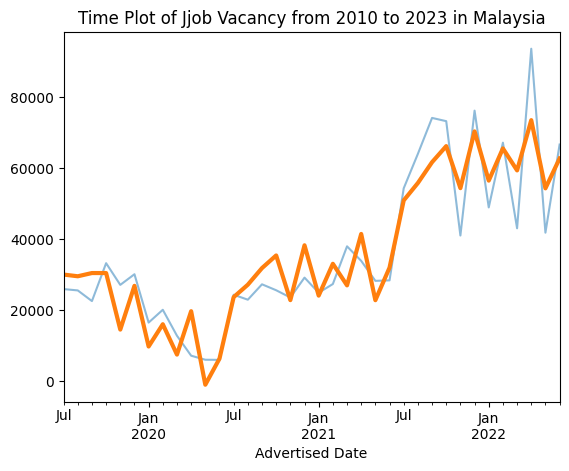

In [225]:
ax = y.plot(alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Jjob Vacancy from 2010 to 2023 in Malaysia')

## Linear Regression Accuracy Test

In [226]:
len(y_pred)
len(y_fore)
len(test.Total)

9

In [227]:
rms = sqrt(mean_squared_error(test.Total,y_fore))
print("RMSE: ", rms)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test.Total, y_fore)
print("MAE: ", mae)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test.Total, y_fore)
print("MAPE: ", mape)

RMSE:  23124.871331655446
MAE:  21685.234470197
MAPE:  34.64392814776959


# Use ETS to forecast

c:\Users\TAN YU JING\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\TAN YU JING\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2023-04-01    67346.193401
2023-05-01    64070.107129
2023-06-01    64122.075862
2023-07-01    85863.869122
2023-08-01    89607.488045
2023-09-01    96467.188463
2023-10-01    93985.207577
2023-11-01    75557.907671
2023-12-01    95173.421336
2024-01-01    83881.979489
2024-02-01    86763.412305
2024-03-01    87782.174454
Freq: MS, dtype: float64


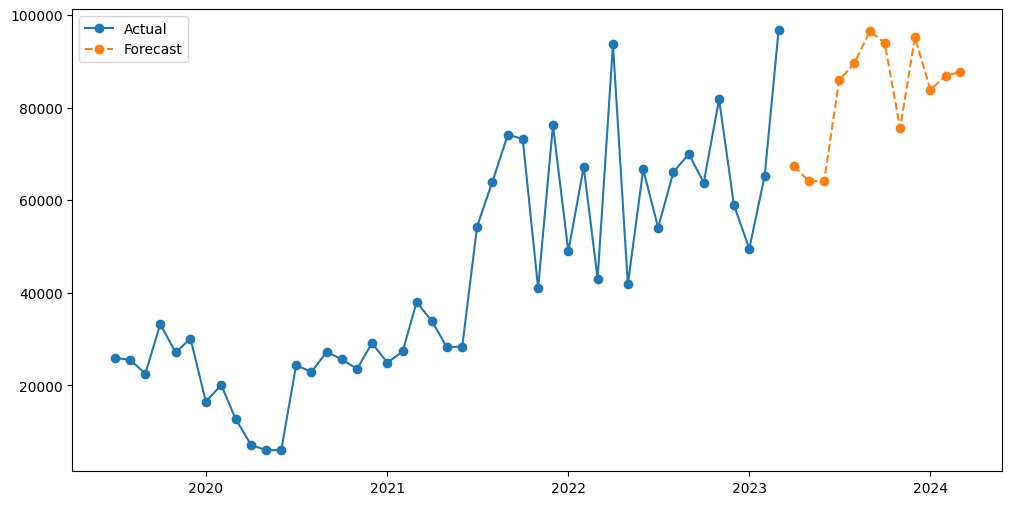

In [241]:
model = ExponentialSmoothing(df, trend='add', seasonal='add', seasonal_periods=12)  
model_fit = model.fit()
forecast = model_fit.forecast(steps= 12)

plt.figure(figsize=(12, 6))
plt.plot(df, label='Actual', linestyle='-', marker='o')
plt.plot(forecast, label='Forecast', linestyle='--', marker='o')
plt.legend()

print(forecast)